# Tutorial

We will do the assembly and merging using the example data in the doc/tutorial_data directory in the following order:

1. Preparing sample info spreadsheet
2. Preparing inputs
3. Assembling individual samples
4. Evalulation of individual assemblies
5. Preparing for merge
6. Merging
7. Evaluation of the merged assembly
8. Annotating merged assembly

The example data is the chromosome 1 portion of the RNASeq data from the neurons in superior central nucleus raphe, medial part (CSm) and dosal nucleus raphe (DR) in Fev-Cre mouse line which labels serotoninergic neurons.  (Fev-Cre is also called ePet-Cre.) 


First we will change the logging level for jupyter notebook and enable inline matplotlib figure:

In [1]:
# This is to change logging level of jupyter notebook
try:
    from importlib import reload # for python 3
except:
    pass
import logging
reload(logging)
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

# This is to show matplotlib output in the notebook
%matplotlib inline
import matplotlib.pylab as P

## Sample Info

For this tutorial, we will use the Excel file **sampleinfo.xlsx** in the tests/data directory. Following fields are required:

- **name**: unique sample name
- **mapbed**: name (or path) of BED file containing mapped reads
- **sjtab**: name (or path) of STAR SJ.out.tab output file


In [2]:
import pandas as PD

si = PD.read_excel('tutorial_data/sampleinfo.xlsx')
print(si[['name','mapbed','sjtab']])

                    name                             mapbed  \
0   Fev_DR_m70_1623.chr1   Fev_DR_m70_1623_star.chr1.bed.gz   
1  Fev_CSm_m70_1624.chr1  Fev_CSm_m70_1624_star.chr1.bed.gz   
2   Fev_DR_m71_1625.chr1   Fev_DR_m71_1625_star.chr1.bed.gz   
3  Fev_CSm_m71_1626.chr1  Fev_CSm_m71_1626_star.chr1.bed.gz   

                              sjtab  
0   Fev_DR_m70_1623.chr1.SJ.out.tab  
1  Fev_CSm_m70_1624.chr1.SJ.out.tab  
2   Fev_DR_m71_1625.chr1.SJ.out.tab  
3  Fev_CSm_m71_1626.chr1.SJ.out.tab  


The read mapping output from STAR is a BAM file. We convert the BAM file to BED file. You can do this using **bedtools bamtobed** command, or using the wrapper [jgem.bedtools.bam2bed](modules.html#jgem.bedtools.bam2bed):

```python
from jgem import bedtools as BT
BT.bam2bed(bam_path,bed_path)
```

STAR also creates a file named SJ.out.tab which contains junction information. 

First, we'll create columns containing actual paths of these files in the sampleinfo dataframe.

In [3]:
import os

BASEDIR = './tutorial_data'
si['bed_path'] = [os.path.join(BASEDIR, "BED", x) for x in si['mapbed']]
si['sjtab_path'] =  [os.path.join(BASEDIR, "SJ", x) for x in si['sjtab']]

print(si[['name','bed_path','sjtab_path']])

                    name                                           bed_path  \
0   Fev_DR_m70_1623.chr1  ./tutorial_data/BED/Fev_DR_m70_1623_star.chr1....   
1  Fev_CSm_m70_1624.chr1  ./tutorial_data/BED/Fev_CSm_m70_1624_star.chr1...   
2   Fev_DR_m71_1625.chr1  ./tutorial_data/BED/Fev_DR_m71_1625_star.chr1....   
3  Fev_CSm_m71_1626.chr1  ./tutorial_data/BED/Fev_CSm_m71_1626_star.chr1...   

                                          sjtab_path  
0  ./tutorial_data/SJ/Fev_DR_m70_1623.chr1.SJ.out...  
1  ./tutorial_data/SJ/Fev_CSm_m70_1624.chr1.SJ.ou...  
2  ./tutorial_data/SJ/Fev_DR_m71_1625.chr1.SJ.out...  
3  ./tutorial_data/SJ/Fev_CSm_m71_1626.chr1.SJ.ou...  


## Preparing Inputs to the assembler

We need a BIGWIG file containing normalized coverages and an appropriately formatted BED file containing junction information for the inputs to the assembler.

To normalize coverage, we use average coverage which is the number of the total mapped base pairs divided by the number of covered base pairs. This can be calculated using  [jgem.bedtools.get_total_bp_bedfile](modules.html#jgem.bedtools.get_total_bp_bedfile):

Now normalized BIGWIG coverage files can be generated using [jgem.bedtools.bed2bw](modules.html#jgem.bedtools.bed2bw) function:

In [ ]:
%%time
# first prepare destination
OUTDIR = './tutorial_out'
si['bw_path'] = [os.path.join(OUTDIR, "bigwig/{0}.bw".format(x)) for x in si['name']]
# then make coverages BIGWIG from BED (~ 2 min)
from jgem import utils as UT
from jgem import bedtools as BT
chromsizes = UT.chromsizes('mm10') # a file containing chromosome names and sizes
for bedfile, bwfile in si[['bed_path','bw_path']].values:
    BT.bed2bw(bedfile, chromsizes, bwfile)

In [6]:
ls ./tutorial_out/bigwig/*

../tests/data/bigwig/Fev_CSm_m70_1624.chr1.bw
../tests/data/bigwig/Fev_CSm_m71_1626.chr1.bw
../tests/data/bigwig/Fev_DR_m70_1623.chr1.bw
../tests/data/bigwig/Fev_DR_m71_1625.chr1.bw


To generate junction files from SJ.out.tab, use function [jgem.gtfgffbed.sjtab2sjbed](modules.html#jgem.gtfgffbed.sjtab2sjbed):

In [7]:
%%time
# sjbed destination
si['sjbed_path'] = [os.path.join(BASEDIR, "sjbed/{0}.sj.bed.gz".format(x)) for x in si['name']]
# SJ.out.tab => sjbed
from jgem import gtfgffbed as GGB
for sjtab, sjbed in si[['sjtab_path','sjbed_path']].values:
    GGB.sjtab2sjbed(sjtab,sjbed)

CPU times: user 247 ms, sys: 45.7 ms, total: 292 ms
Wall time: 391 ms


In [8]:
ls ../tests/data/SJ/*chr1.sj.bed.gz

../tests/data/SJ/Fev_CSm_m70_1624.chr1.sj.bed.gz
../tests/data/SJ/Fev_CSm_m71_1626.chr1.sj.bed.gz
../tests/data/SJ/Fev_DR_m70_1623.chr1.sj.bed.gz
../tests/data/SJ/Fev_DR_m71_1625.chr1.sj.bed.gz


Let's check the content of generated SJBED file.

In [9]:
sj = GGB.read_sj(sjbed)
print(sj.head())

    chr       st       ed                 name  ucnt strand  mcnt
0  chr1  3121707  3142317   CT/AC-k0-u4-m0-o46     4      -     0
1  chr1  3207318  3213438  CT/AC-k0-u10-m0-o47    10      -     0
2  chr1  3271573  3302745   GT/AG-k0-u0-m1-o37     0      +     1
3  chr1  3421902  3670551  CT/AC-k1-u20-m0-o43    20      -     0
4  chr1  3660890  3670551   CT/AC-k0-u2-m0-o41     2      -     0


### SJBED file format

As shown above, the tab separated junction file should contain:

- **chr**:  chromosome name
- **st**: start position
- **ed**: end position
- **name**: junction name
- **ucnt**: unique reads
- **strand**: strand of junction
- **mcnt**: non-unique (multimapping) reads


## Assembling individual samples

Use [FileNames class](modules.html#jgem.filenames.FileNames) to specify inputs (bigwig file and sjbed file) and output directory, then use [Assembler class](modules.html#jgem.assembler.Assembler) to do the assembly.

INFO:SELECTSJ ====================
INFO: #sj:7660=>7649
INFO: time: 0.408s
INFO:REMOVEJIE ====================
INFO: #sj:7649=>7640, jie 9
INFO: time: 1.830s
INFO:SJ2EX ====================
INFO:#sj:7640=>7640 after ureadth, mreadth
INFO: #ex:8127, #sj:7640
INFO: time: 0.106s
INFO:MERGEEXONS ====================
INFO: #ex:8205
INFO: time: 0.203s
INFO:FINDEDGES ====================
INFO: time: 1.730s
INFO:FIXSTRAND ====================
INFO: time: 0.359s
INFO:EDGEFIXER ====================
INFO: time: 14.693s
INFO:FINDIRETS ====================
INFO:#irets candidates:171
INFO:169 irets found
INFO: time: 6.094s
INFO:FINDSECOVTH ====================
INFO: SECOVTH=9.509753345884835
INFO: time: 6.135s
INFO:FINDSE ====================
INFO:#candidate SE:8041
INFO:  processing 8041 SE candidates
INFO:#candidate SE after _fix_se_ext:7957
INFO:write exons ...=> assemble.exons0.txt.gz
INFO: time: 41.542s
INFO:CALCCOV ====================
INFO: time: 3.143s
INFO:SETINFO ====================
INFO:

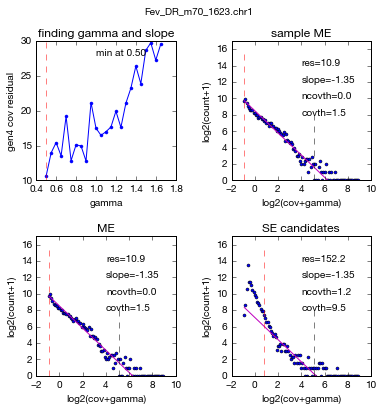

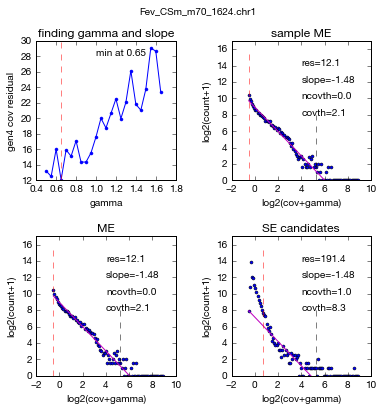

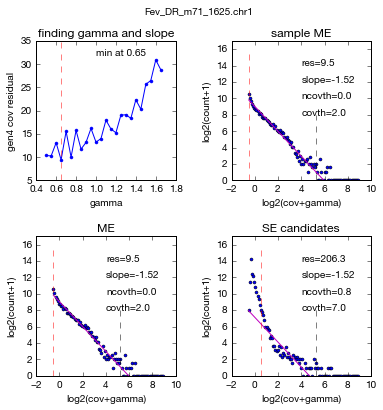

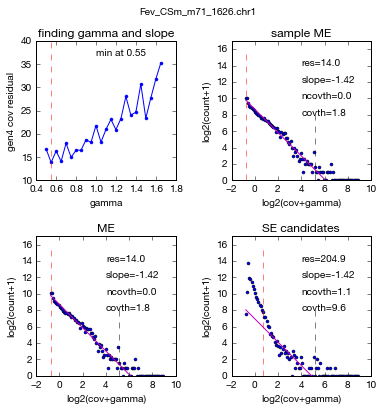

In [12]:
# assemble 4 samples takes about ~10 min 
from jgem import filenames as FN
from jgem import assembler as AS
for name,bwfile,sjfile in si[['name','bw_path','sjbed_path']].values:
    fn = FN.FileNames(name, bwfile, sjfile, outdir='../tests/out')
    p = AS.Assembler(fn,saveintermediates=False)
    p.assemble()

Generated figures visualize the process of finding coverage threshold for single exons. (See ...)

In the output directory, several files are generated:

In [11]:
ls ../tests/out/Fev_DR_m70_1623*

../tests/out/Fev_DR_m70_1623.chr1.assemble.params.txt.gz
../tests/out/Fev_DR_m70_1623.chr1.assemble.stats.txt
../tests/out/Fev_DR_m70_1623.chr1.ci.txt.gz
../tests/out/Fev_DR_m70_1623.chr1.ex.bed.gz
../tests/out/Fev_DR_m70_1623.chr1.ex.txt.gz
../tests/out/Fev_DR_m70_1623.chr1.findsecovth.params.txt
../tests/out/Fev_DR_m70_1623.chr1.findsecovth.pdf
../tests/out/Fev_DR_m70_1623.chr1.genes.bed.gz
../tests/out/Fev_DR_m70_1623.chr1.selectsj.sj2.txt.gz
../tests/out/Fev_DR_m70_1623.chr1.sj.bed.gz
../tests/out/Fev_DR_m70_1623.chr1.sj.txt.gz


Main outputs are files with .ex.txt.gz, .sj.txt.gz suffixes. These contain exons and junctions in tab separated format. BED files are also generated for viewing elements (genes,exons,junctions) with browsers like IGV (https://www.broadinstitute.org/igv/). The screenshot below is a segment of chromosome 1 showing genes.bed files from the 4 samples. 

![](_static/GD1YM1XSXBVB8NOM2KDWF3FB0H5DE3OW.png)

Other files (assemble.params.txt.gz, assemble.stats.txt.gz, findsecovth.params.txt.gz, findsecovth.pdf) contain parameters and statistics of the assembly.

## Evaluation of individual assemblies

We will evaluate the assemblies against [Gencode.VM4 annotation](http://www.gencodegenes.org/mouse_releases/4.html). For this, we use  [EvalNames class](modules.html#jgem.evalutate.EvalNames) and [EvalMatch class](modules.html#jgem.evalutate.EvalMatch). 

In [13]:
# Evaluate against Gencode.VM4 (~1 min)
from jgem import evaluate as EV
ens = {} # keep EvalNames objects
ems = {} # keep EvalMatch object
# Gencode.VM4
en_gen4 = EV.EvalNames('../tests/data/assemblies/gencode.vM4.chr1', code='gen4', outdir='../tests/eval/')
# assign sample code
si['scode'] = [x.split('_')[-1].split('.')[0] for x in si['name']]
# For each sample
for scode, name, bwfile, sjfile in si[['scode','name','bw_path','sjbed_path']].values:
    print('process {0}...'.format(name))
    sjexbase = '../tests/out/'+name # prefix to .ex.txt.gz and .sj.txt.gz files
    assemblycode = 'a'+str(scode) # assembly identifier
    datacode = 'd'+str(scode) # data identifier
    ens[name] = EV.EvalNames(sjexbase,  code=assemblycode, outdir='../tests/eval/') 
    ems[name] = EV.EvalMatch(en_gen4, ens[name], bwfile, sjfile, datacode=datacode, binsize=100) 
    ems[name].calculate()

process Fev_DR_m70_1623.chr1...


INFO:[i] detected1:7803,	matched:5584,	(detected2:5814),	ratio:0.72,	(ratio2:0.96)
INFO:[5] detected1:2346,	matched:1142,	(detected2:1966),	ratio:0.49,	(ratio2:0.58)
INFO:[3] detected1:2632,	matched:1162,	(detected2:2067),	ratio:0.44,	(ratio2:0.56)
INFO:[s] detected1:914,	matched:102,	(detected2:559),	ratio:0.11,	(ratio2:0.18)
INFO:[j] detected1:6892,	matched:6722,	(detected2:7329),	ratio:0.98,	(ratio2:0.92)
INFO:[5b] detected1:2346,	matched:1602,	(detected2:10406),	ratio:0.68,	(ratio2:0.15)
INFO:[3b] detected1:2632,	matched:1753,	(detected2:10406),	ratio:0.67,	(ratio2:0.17)
INFO:[sb] detected1:914,	matched:267,	(detected2:10406),	ratio:0.29,	(ratio2:0.03)


process Fev_CSm_m70_1624.chr1...


INFO:[i] detected1:7947,	matched:5859,	(detected2:6173),	ratio:0.74,	(ratio2:0.95)
INFO:[5] detected1:2423,	matched:1189,	(detected2:2036),	ratio:0.49,	(ratio2:0.58)
INFO:[3] detected1:2727,	matched:1237,	(detected2:2251),	ratio:0.45,	(ratio2:0.55)
INFO:[s] detected1:953,	matched:115,	(detected2:551),	ratio:0.12,	(ratio2:0.21)
INFO:[j] detected1:7153,	matched:6998,	(detected2:7799),	ratio:0.98,	(ratio2:0.90)
INFO:[5b] detected1:2423,	matched:1671,	(detected2:11011),	ratio:0.69,	(ratio2:0.15)
INFO:[3b] detected1:2727,	matched:1871,	(detected2:11011),	ratio:0.69,	(ratio2:0.17)
INFO:[sb] detected1:953,	matched:294,	(detected2:11011),	ratio:0.31,	(ratio2:0.03)


process Fev_DR_m71_1625.chr1...


INFO:[i] detected1:8242,	matched:5950,	(detected2:6342),	ratio:0.72,	(ratio2:0.94)
INFO:[5] detected1:2524,	matched:1201,	(detected2:2235),	ratio:0.48,	(ratio2:0.54)
INFO:[3] detected1:2846,	matched:1304,	(detected2:2529),	ratio:0.46,	(ratio2:0.52)
INFO:[s] detected1:993,	matched:107,	(detected2:589),	ratio:0.11,	(ratio2:0.18)
INFO:[j] detected1:7336,	matched:7149,	(detected2:8035),	ratio:0.97,	(ratio2:0.89)
INFO:[5b] detected1:2524,	matched:1707,	(detected2:11695),	ratio:0.68,	(ratio2:0.15)
INFO:[3b] detected1:2846,	matched:1942,	(detected2:11695),	ratio:0.68,	(ratio2:0.17)
INFO:[sb] detected1:993,	matched:294,	(detected2:11695),	ratio:0.30,	(ratio2:0.03)


process Fev_CSm_m71_1626.chr1...


INFO:[i] detected1:8034,	matched:5726,	(detected2:6025),	ratio:0.71,	(ratio2:0.95)
INFO:[5] detected1:2492,	matched:1258,	(detected2:2185),	ratio:0.50,	(ratio2:0.58)
INFO:[3] detected1:2737,	matched:1245,	(detected2:2386),	ratio:0.45,	(ratio2:0.52)
INFO:[s] detected1:974,	matched:100,	(detected2:602),	ratio:0.10,	(ratio2:0.17)
INFO:[j] detected1:7085,	matched:6909,	(detected2:7653),	ratio:0.98,	(ratio2:0.90)
INFO:[5b] detected1:2492,	matched:1754,	(detected2:11198),	ratio:0.70,	(ratio2:0.16)
INFO:[3b] detected1:2737,	matched:1867,	(detected2:11198),	ratio:0.68,	(ratio2:0.17)
INFO:[sb] detected1:974,	matched:273,	(detected2:11198),	ratio:0.28,	(ratio2:0.02)


INFO outputs are as follows: 

- detected1: counts of gencode exons/junctions with positive coverage
- matched: number of matched exons/junctions 
- detected2: counts of elements in the assembly 
- ratio: matched/detected1
- ratio2: matched/detected2 

These are assesed within different exon classes: 

- **i**: internal exon (exons bounded by splice junctions)
- **5**: 5'exons
- **3**: 3'exons
- **s**: single exons
- **j**: junctions
    
Classes with **b**, (**5b**,**3b**,**sb**) allow matching to different classes of exons. 

Matching exons with junction boundary requires the boundaries to match. That is, to match internal exons, they have to be exactly the same (including strand). To match 5'exons, donor site has to the same but the other side does not have to be. To match single exon, they just need to have some overlap. 

So, we have quite good detection of junctions. About 70% of internal exons are detected. 5',3' exons are worse (< 50%) but if allowed to match to other class of exons, then detection rates get close to the internal exons. Single exon detection rates are bad and about 10%.


We can visualize the detection percentages as follows.

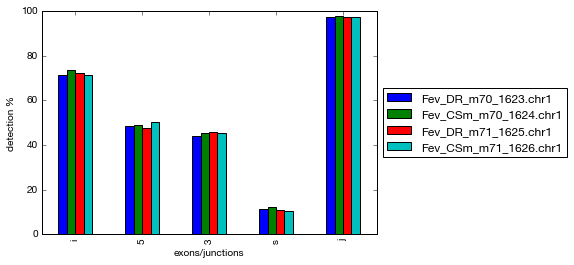

In [14]:
# EvalMatch.get_detection_percentages returns a dataframe containing detection percentages 
dp = PD.DataFrame({n:ems[n].get_detection_percentages().stack() for n in ems})
tgt = ['i','5','3','s','j']
dp1 = dp.ix[[(x,'%detected 1') for x in tgt]][si['name'].values]
dp1.index = tgt
ax = dp1.plot(kind='bar', legend=False, figsize=(6,4))
ax.set_ylabel('detection %')
ax.set_xlabel('exons/junctions')
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

We can also plot the detection sensitivity against coverages. We expect the detection rate is better at the bigger coverage.

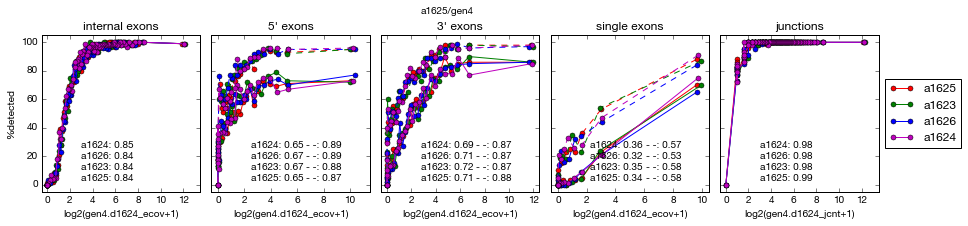

In [15]:
colors = ['ro-','go-','bo-','mo-']
for i,name in enumerate(ems):
    em = ems[name]
    if i==0:
        axr = em.plot_sensitivity(color=colors[i])
    else:
        axr = em.plot_sensitivity(color=colors[i], axr=axr, ypos=i)

These plots show percent of detected exons calculated in bins sorted by coverage (binsize 100). Numbers in inset indicate normalized area under the curve (AUC, which ranges from 0 to 1).  Dashed lines in 5',3' and single exon panels correspond to 5b, 3b, sb category. 

How about the precision of the match? We can assess this by length ratio of matched exons:

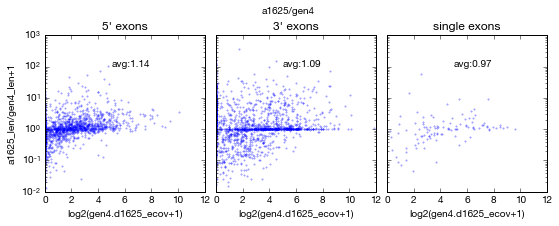

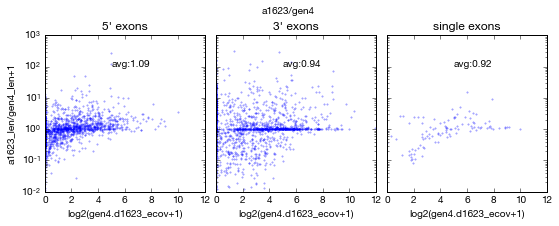

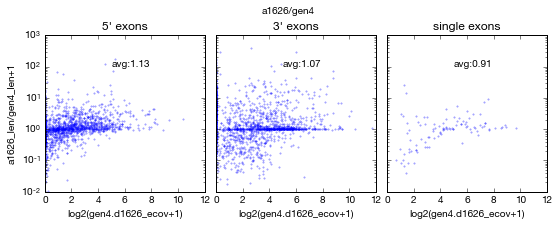

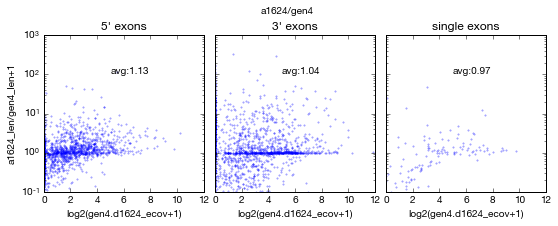

In [16]:
for name in ems:
    ems[name].plot_ratio()

Averages shown inside are geometric averages. Overall length tends to be a bit longer. (Matching of internal exons and junctions always produce ratio of 1, so they are not shown.)

For some genes, we see partial or disconnected reconstruction of the structure. An example is shown below:

![](_static/XLYS4AQF3MKU4PDJ17VOM2LBW63I566O.png)

These incomplete reconstructions are due to missing junctions or insufficient exon coverages.

To evaluate the *completeness* of the reconstruction, we calculate three measures. One is the ratio of gene length. We call this GLC (gene length completenesss). The second measure is the ratio of exon counts (ECC, exon count completeness), and the third is the ratio of junction counts (JCC, junction count completeness).

We can visualize these measures by [plot_completeness](modules.html#jgem.evaluate.EvalMatch.plot_completeness) method.

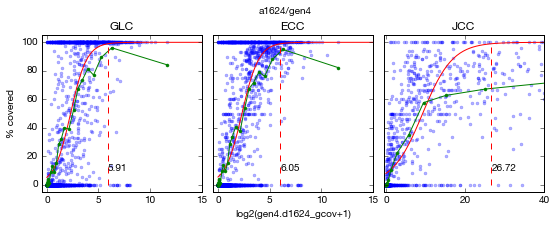

In [28]:
axr = ems[name].plot_completeness(pw='fdat', ca='g.-', cf='r-',  cd='b.', xlim=[0,15], xlimjcc=[0,40])

Blue dots are genes, green dots are binned averages, red lines are sigmoid function fit to blue dots and red dashes are 99% position of the sigmoidal fit. 

As expected, genes with low coverages tends to have incomplete reconstructions.

Below, we'll plot binned averages of completeness measures for all 4 samples.

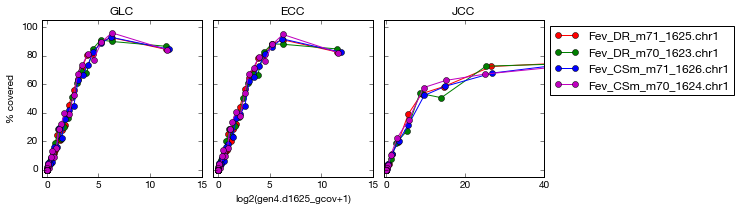

In [31]:
colors = ['ro-','go-','bo-','mo-']
for i,name in enumerate(ems):
    em = ems[name]
    if i==0:
        axr = em.plot_completeness(pw='a', ca=colors[i], label=name, title='')
    else:
        axr = em.plot_completeness(pw='a', ca=colors[i], xlim=(0,15),xlimjcc=(0,40), axr=axr, label=name)
P.legend(bbox_to_anchor=(1,1),loc='upper left')

## Preparing for merge

Since individual cell types express only subsets of the genes, merging assembies is necessary to obtain a more complete picture of the transcriptomes. Moreover, merging should also improve the sensitivity and the completeness of the reconstruction.

For merging, we will repeat the assembly process but uses aggregated junctions and coverage bigwigs generated from all exons from all assemblies. We need to prepare these two kinds of files first. For this, we use [MergeInputs class](modules.html#jgem.merge.MergeInputs). 


In [32]:
from jgem import merge as MG
fni = MG.MergeInputNames(sampleinfo=si, code='FevM', outdir='../tests/mout')
mi = MG.MergeInputs(fnobj=fni, genome='mm10', np=3, th_detected=0, th_maxcnt1=0)

We need to assign **sjexpre** column to the sampleinfo:

In [33]:
# prefix to *.ex.txt.gz and *.sj.txt.gz files
si['sjexpre'] = [os.path.join('../tests/out/', x) for x in si['name']]

To create bigwigs:

In [51]:
reload(MG)
mi.__class__ = MG.MergeInputs
# for k,v in ems.items():
#     v.__class__ = EV.EvalMatch

In [49]:
%%time
mi.make_ex_bigwigs()

To make aggreagated junction files:

In [52]:
mi.make_sj_bed()

INFO:selectsj: in 11398
INFO:selectsj: 104 smaller than th_ratio(0.001)
INFO:selectsj: 0 smaller than th_detected(0)
INFO:selectsj: 0 smaller than th_maxcnt1(0)
INFO:selectsj: 9236 larger than th_maxcnt2(1)
INFO:#selected SJ:11294<=11398


To make average bigwig coverage file (average of original individual bigwig coverages, different from bigwigs generated above by make_ex_bigwigs(), which are based on assembled exons):

In [53]:
%%time
mi.aggregate_bigwigs()

CPU times: user 121 ms, sys: 175 ms, total: 296 ms
Wall time: 30.2 s


Output files are:

In [54]:
ls ../tests/mout/FevM*

../tests/mout/FevM.allsample.bw        ../tests/mout/FevM.sj.n.bed.gz
../tests/mout/FevM.allsj.stats.txt.gz  ../tests/mout/FevM.sj.p.bed
../tests/mout/FevM.allsj.txt.gz        ../tests/mout/FevM.sj.p.bed.gz
../tests/mout/FevM.ex.men.bw           ../tests/mout/FevM.sj0.bed.gz
../tests/mout/FevM.ex.mep.bw           ../tests/mout/FevM.sj2.txt.gz
../tests/mout/FevM.ex.se.bw


Bigwigs generated from assembly exons are separated into multi-exon positive strand, negative strand and single exons:

    .ex.mep.bw
    .ex.men.bw
    .ex.se.bw
    
Similarly junctions are also separated into two strands:

    .sj.p.bed.gz
    .sj.n.bed.gz
    
Averaged bigwig is:

    .allsample.bw: 
    
Other files contain stats.

## Merging

Once we have inputs prepared, we use [MergeAssemble class](modules.html#jgem.merge.MergeAssemble) to do the merging.


In [55]:
reload(BT)
reload(AS)
reload(MG)
fna.__class__ = MG.MergeAssemblyNames
fni.__class__ = MG.MergeInputNames
ma.__class__ = MG.MergeAssemble

In [56]:
fna = MG.MergeAssemblyNames('FevA', outdir='../tests/mout')
ma = MG.MergeAssemble(fni,fna,np=3,saveintermediates=False)

In [57]:
ma.assemble()

INFO:CHECKSJSUPPORT ====================
INFO: #sj: 5348=>4900
INFO: time: 0.572s
INFO:REMOVEJIE ====================
INFO: #sj:4900=>4840, jie 60
INFO: time: 0.308s
INFO:SJ2EX ====================
INFO:#sj:4840=>4840 after ureadth, mreadth
INFO: #ex:4922, #sj:4840
INFO: time: 0.085s
INFO:MERGEEXONS ====================
INFO: #ex:5751
INFO: time: 0.184s
INFO:FINDEDGES2 ====================
INFO: time: 14.304s
INFO:FIXSTRAND ====================
INFO: time: 0.141s
INFO:FINDIRETS ====================
INFO:#irets candidates:245
INFO:253 irets found
INFO: time: 2.428s
INFO:FIND53IR ====================
INFO:  calculating SECOV...
INFO:write exons ...=> assemble.exons0.txt.gz
INFO: time: 1.816s
INFO:CALCCOV ====================
INFO: time: 0.654s
INFO:SETINFO ====================
INFO: time: 0.201s
INFO:FINDGENES ====================
INFO:finding genes (connected components)...
INFO: time: 1.455s
INFO:assigning gidx...
INFO: #genes:ME570, SE(before selection)11
INFO: time: 1.490s
INFO:SELEC

Output files are:

In [59]:
ls ../tests/mout/FevA*

../tests/mout/FevA.ci.txt.gz
../tests/mout/FevA.ex.bed.gz
../tests/mout/FevA.ex.txt.gz
../tests/mout/FevA.genes.bed.gz
../tests/mout/FevA.genes.txt.gz
../tests/mout/FevA.men.assemble.stats.txt
../tests/mout/FevA.mep.assemble.stats.txt
../tests/mout/FevA.se.bed.gz
../tests/mout/FevA.sj.bed.gz
../tests/mout/FevA.sj.txt.gz


Looking at .genes.bed file with IGV, we find previously incomplete reconstructions are now merged into one complete structure:

![](_static/HF0TPO3FMEPGDMG1TQW3Y34I8QIUYB42.png)

To evaluate the merging quantitatively, we use EvalMatch class as before:

In [60]:
ems2 = {} # keep EvalMatch object 
en_m = EV.EvalNames('../tests/mout/FevA',  code='FevA', outdir='../tests/eval/') 
# for each sample data generate EvalMatch between the merged assembly and the gencode4
for scode, name, bwfile, sjfile in si[['scode','name','bw_path','sjbed_path']].values:
    print('process {0}...'.format(name))
    datacode = 'd'+str(scode)
    ems2[name] = EV.EvalMatch(en_gen4, en_m, bwfile, sjfile, datacode=datacode, binsize=100) 
    ems2[name].calculate()

process Fev_DR_m70_1623.chr1...


INFO:[i] detected1:7803,	matched:6346,	(detected2:7008),	ratio:0.81,	(ratio2:0.91)
INFO:[5] detected1:2346,	matched:1257,	(detected2:1472),	ratio:0.54,	(ratio2:0.85)
INFO:[3] detected1:2632,	matched:1313,	(detected2:1724),	ratio:0.50,	(ratio2:0.76)
INFO:[s] detected1:914,	matched:148,	(detected2:1125),	ratio:0.16,	(ratio2:0.13)
INFO:[j] detected1:6892,	matched:6812,	(detected2:7396),	ratio:0.99,	(ratio2:0.92)
INFO:[5b] detected1:2346,	matched:1777,	(detected2:11329),	ratio:0.76,	(ratio2:0.16)
INFO:[3b] detected1:2632,	matched:2003,	(detected2:11329),	ratio:0.76,	(ratio2:0.18)
INFO:[sb] detected1:914,	matched:322,	(detected2:11329),	ratio:0.35,	(ratio2:0.03)


process Fev_CSm_m70_1624.chr1...


INFO:[i] detected1:7947,	matched:6432,	(detected2:7146),	ratio:0.81,	(ratio2:0.90)
INFO:[5] detected1:2423,	matched:1278,	(detected2:1561),	ratio:0.53,	(ratio2:0.82)
INFO:[3] detected1:2727,	matched:1337,	(detected2:1776),	ratio:0.49,	(ratio2:0.75)
INFO:[s] detected1:953,	matched:152,	(detected2:1212),	ratio:0.16,	(ratio2:0.13)
INFO:[j] detected1:7153,	matched:7069,	(detected2:7838),	ratio:0.99,	(ratio2:0.90)
INFO:[5b] detected1:2423,	matched:1820,	(detected2:11695),	ratio:0.75,	(ratio2:0.16)
INFO:[3b] detected1:2727,	matched:2055,	(detected2:11695),	ratio:0.75,	(ratio2:0.18)
INFO:[sb] detected1:953,	matched:340,	(detected2:11695),	ratio:0.36,	(ratio2:0.03)


process Fev_DR_m71_1625.chr1...


INFO:[i] detected1:8242,	matched:6526,	(detected2:7264),	ratio:0.79,	(ratio2:0.90)
INFO:[5] detected1:2524,	matched:1294,	(detected2:1639),	ratio:0.51,	(ratio2:0.79)
INFO:[3] detected1:2846,	matched:1377,	(detected2:1876),	ratio:0.48,	(ratio2:0.73)
INFO:[s] detected1:993,	matched:154,	(detected2:1284),	ratio:0.16,	(ratio2:0.12)
INFO:[j] detected1:7336,	matched:7222,	(detected2:8087),	ratio:0.98,	(ratio2:0.89)
INFO:[5b] detected1:2524,	matched:1870,	(detected2:12063),	ratio:0.74,	(ratio2:0.16)
INFO:[3b] detected1:2846,	matched:2122,	(detected2:12063),	ratio:0.75,	(ratio2:0.18)
INFO:[sb] detected1:993,	matched:337,	(detected2:12063),	ratio:0.34,	(ratio2:0.03)


process Fev_CSm_m71_1626.chr1...


INFO:[i] detected1:8034,	matched:6405,	(detected2:7122),	ratio:0.80,	(ratio2:0.90)
INFO:[5] detected1:2492,	matched:1336,	(detected2:1548),	ratio:0.54,	(ratio2:0.86)
INFO:[3] detected1:2737,	matched:1348,	(detected2:1788),	ratio:0.49,	(ratio2:0.75)
INFO:[s] detected1:974,	matched:149,	(detected2:1238),	ratio:0.15,	(ratio2:0.12)
INFO:[j] detected1:7085,	matched:6984,	(detected2:7705),	ratio:0.99,	(ratio2:0.91)
INFO:[5b] detected1:2492,	matched:1892,	(detected2:11696),	ratio:0.76,	(ratio2:0.16)
INFO:[3b] detected1:2737,	matched:2072,	(detected2:11696),	ratio:0.76,	(ratio2:0.18)
INFO:[sb] detected1:974,	matched:329,	(detected2:11696),	ratio:0.34,	(ratio2:0.03)


To visualize detection percentage:

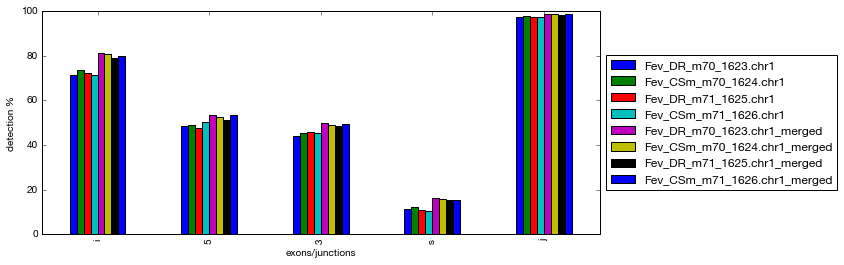

In [61]:
for n in ems2:
    dp[n+'_merged'] = ems2[n].get_detection_percentages().stack()
tgt = ['i','5','3','s','j']
cols = list(si['name'])+[x+'_merged' for x in si['name']]
dp1 = dp.ix[[(x,'%detected 1') for x in tgt]][cols]
dp1.index = tgt
ax = dp1.plot(kind='bar', legend=False, figsize=(10,4))
ax.set_ylabel('detection %')
ax.set_xlabel('exons/junctions')
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

So we have much better detection of internal exons (~10% improvement) and slight improvements in the detection of 5'exons, 3'exons and junctions. 

We can also see the improvements in the gene structure reconstruction in the changes in GLC,ECC,JCC:

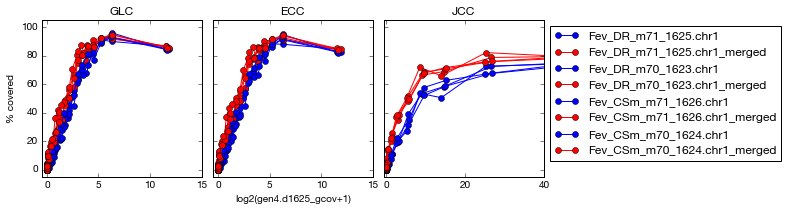

In [62]:
for i,name in enumerate(ems):
    if i==0:
        axr = ems[name].plot_completeness(pw='a', ca='bo-', label=name, title='')
        axr = ems2[name].plot_completeness(pw='a', ca='ro-', label=name+'_merged', axr=axr)
    else:
        axr = ems[name].plot_completeness(pw='a', ca='bo-', label=name, axr=axr)
        axr = ems2[name].plot_completeness(pw='a', ca='ro-', label=name+'_merged', axr=axr, 
                                          xlim=(0,15), xlimjcc=(0,40))
        
P.legend(bbox_to_anchor=(1,1),loc='upper left')

## Annotating assembly

Once we have an assembly, we want to know which gene model corresponds to which known gene. We do this using [Comparator class](modules.html#jgem.annotate.Comparator). 

In [64]:
from jgem import annotate as AN
g4sjexpre = '../tests/data/assemblies/gencode.vM4.chr1'
mergepre = '../tests/mout/FevA'
outdir = '../tests/aout'
cref = AN.ComparatorNames(g4sjexpre, 'gen4', outdir)
ctgt = AN.ComparatorNames(mergepre, 'FevC', outdir)
cp = AN.Comparator(cref, ctgt, gnamecol='gene_name', gidxcol='gene_id')
cp.annotate(overwrite=False)

When overwrite is True, it overwrites the original sj,ex files. If False, it creats files in the output direcotry:

In [66]:
ls ../tests/aout/*

../tests/aout/FevC.gen4.ex.txt.gz  ../tests/aout/FevC.gen4.sj.txt.gz


Let's check the contents of the exon file:

In [67]:
ex = UT.read_pandas('../tests/aout/FevC.gen4.ex.txt.gz')
ex.columns

Index(['chr', 'st', 'ed', 'name', 'sc1', 'strand', '_id', '_gidx', 'gname',
       'cat', 'ptyp', 'cov', 'len', 'a_id', 'd_id', 'a_degree', 'd_degree',
       'a_pos', 'd_pos', 'tlen', 'glen', 'ecov', 'gcov', 'eknown_gen4',
       'etcode_gen4', 'intergenic_gen4', 'ex_as_ovl_gen4', 'gene_as_ovl_gen4',
       'gknown_gen4', 'gtcode_gen4', 'gen4_gidxs', 'gen4_gidx0', 'gen4_syms',
       'gen4_sym0'],
      dtype='object')

In [68]:
acols = ['chr','st','ed','strand','cat','gname','eknown_gen4','etcode_gen4', 
         'intergenic_gen4', 'ex_as_ovl_gen4', 'gene_as_ovl_gen4',
         'gknown_gen4', 'gtcode_gen4','gen4_sym0']
print(ex.head(10)[acols])

    chr       st       ed strand cat   gname eknown_gen4 etcode_gen4  \
0  chr1  3121337  3121706      -   3     NG1           u        u.me   
1  chr1  3142317  3142551      -   5     NG1           u        u.me   
2  chr1  3199728  3207317      -   3     NG2           k        k.me   
3  chr1  3206729  3207317      -   3     NG2           k        k.me   
4  chr1  3213438  3215204      -   5     NG2           k        k.me   
5  chr1  3213438  3216968      -   i     NG2           k        k.me   
6  chr1  3216888  3216968      -   3     NG2           k        k.me   
7  chr1  3266288  3266602      .   s  S50000           u        u.se   
8  chr1  3284679  3285150      .   s  S50001           u        u.se   
9  chr1  3322953  3323492      .   s  S50002           u        u.se   

  intergenic_gen4 ex_as_ovl_gen4 gene_as_ovl_gen4 gknown_gen4 gtcode_gen4  \
0               y              n                n           u        u.me   
1               y              n                n    

Columns are:

    cat: exon category (internal, 5',3',single)
    gname: assembly gene name
    eknown_gen4: exon known against gen4 (k or u)
    etcode_gen4: exon code (k.me: known multi-exon, u.se:unknown single exon, etc.)
    intergenic_gen4: whether the gene is intergenic 
    ex_as_ovl_gen4: exon overlaps with gen4 exon in antisense direction
    gene_as_ovl_gen4: gene overlaps with gen4 gene in antisense direction
    gtcode_gen4: similar to etcode_gen4
    gen4_sym0: Gencode.vM4 gene symbol (0 indicates closest one)
    
    